In [2]:
import pywt
import pywt.data
import cv2
import h5py
from typing import Tuple
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

filename = "data.h5"
original = h5py.File(filename,'r')
keys= [key for key in original.keys()]

## accessing one file

n1 =original.get(keys[0])
arr = n1[()]

#original = arr

(256, 256, 256)

In [4]:
from tqdm.notebook import tqdm

In [16]:
fid = h5py.File(filename,'r')

arr = np.zeros([256,256,256])
for ix,k in enumerate(fid):
    print(k)
    data = fid[k][()]
    if ix==10:
        break
    arr= data + arr
arr = np.array(arr)
arr.shape

c2_F_c001.sdt
c2_F_c002.sdt
c2_F_c003.sdt
c2_F_c004.sdt
c2_F_c005.sdt
c2_F_c006.sdt
c2_F_c007.sdt
c2_F_c008.sdt
c2_F_c009.sdt
c2_F_c010.sdt
c2_F_c011.sdt


(256, 256, 256)

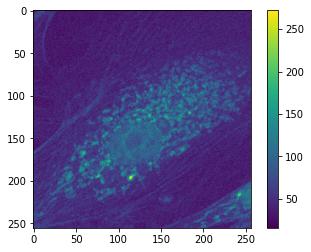

In [19]:
plt.imshow(arr.sum(2))
plt.colorbar()

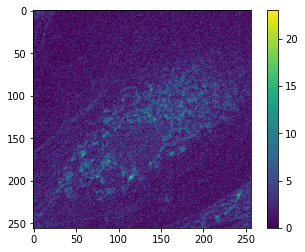

In [22]:
original = arr[:,:,50:56]
plt.imshow(original.sum(2))
plt.colorbar()

In [24]:
undersample_rate = .5
shape = original.shape
shape

(256, 256, 6)

In [58]:
wavelet = 'bior1.3'

# Forward wavelet transform function
def W(X):
    return pywt.dwtn(X, wavelet)

# Inverse wavelet transform function
def W_inv(X_wavelet):
    return pywt.idwtn(X_wavelet, wavelet)

#Optimization
def shrinkage(x, alpha):
    return np.sign(x) * np.maximum(np.abs(x) - alpha, 0)

#Having the mask allows for easier matrix math and less reliance on pywt
def create_sampling_mask(shape, sampling_rate):
    return np.random.rand(*shape) < sampling_rate

#Iterative shrinking optimization
def ista(mask, Y, W, W_inv, tau, lambda_, max_iter=100):
    # Initialize wavelet coefficients with the same structure as Y
    X_wavelet = {key: np.zeros_like(val) for key, val in Y.items()}
    
    for k in range(max_iter):
        # Gradient step
        A_X_wavelet = W_inv(X_wavelet) * mask  # Implicit sampling operation
        gradient = W((A_X_wavelet - W_inv(Y)) * mask)  # Masked gradient
        
        X_wavelet = {key: X_wavelet[key] - tau * gradient[key] for key in X_wavelet}
        
        # Shrinkage step
        X_wavelet = {key: shrinkage(X_wavelet[key], lambda_ * tau) for key in X_wavelet}
    
    X_reconstructed = W_inv(X_wavelet)
    return X_reconstructed, X_wavelet



In [ ]:
 psnr vs  numberofslices, numberoftimebins, alpha, W, W_inv, tau, lambda_, max_iter

In [29]:
import skimage.metrics 
psnr = skimage.metrics.peak_signal_noise_ratio

In [59]:
%%time

# Create sampling mask
mask = create_sampling_mask(shape, undersample_rate)

# Apply the undersampling mask to get Y
undersampled_data = original * mask

# Get the wavelet transform of the undersampled data
Y = W(undersampled_data)

# Set hyperparameters
tau = 0.1
lambda_ = 0.01
max_iter = 100

# Run ISTA algorithm
X_reconstructed, Xw = ista(mask, Y, W, W_inv, tau, lambda_, max_iter)




CPU times: total: 1.77 s
Wall time: 4.72 s


In [41]:
X_reconstructed.min(),X_reconstructed.max()

(-0.19353726103527763, 8.970292339952069)

In [60]:
import skimage.util as sku
Xr = sku.img_as_ubyte(X_reconstructed/X_reconstructed.max())
Xr.min(), Xr.max()

(0, 255)

In [61]:
type(original), type(Xr)

(numpy.ndarray, numpy.ndarray)

In [62]:
# Calculate PSNR and SSIM
psnr_value = psnr(original, Xr,data_range=2**8)
#ssim_value = ssim(arr, X_reconstructed, structural_similarity=True)

print(f"PSNR: {psnr_value}")
#print(f"SSIM: {ssim_value}")


PSNR: 23.72004327833605


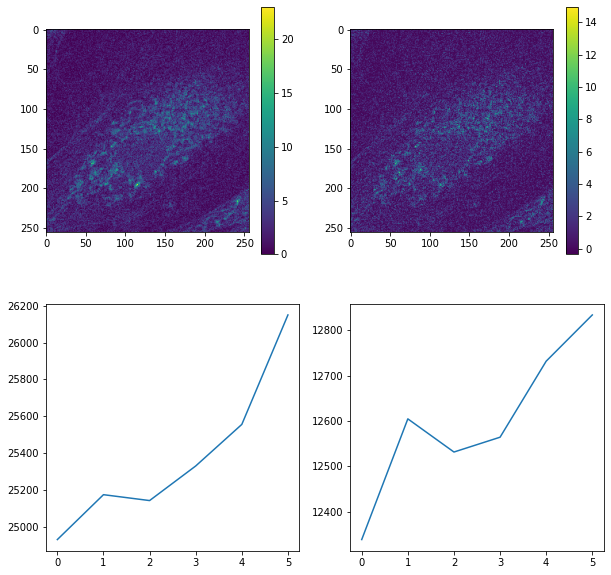

In [63]:
#Want to have something that can detect properties of the image in the space, for example if there are orthogonal lines in a picture can we detect these lines in the space
#Also add better metrics and see if operations are similar
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

original_spectral = original.sum((0,1))
reconstructed_spectral = X_reconstructed.sum((0,1))
im0 = axs[0,0].imshow(original.sum(2))
plt.colorbar(im0)
im1 = axs[0,1].imshow(X_reconstructed.sum(2))
plt.colorbar(im1)
axs[1,0].plot(original_spectral)
axs[1,1].plot(reconstructed_spectral)


In [65]:
Xw.keys()

dict_keys(['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd'])

(130, 130, 5)
(130, 130, 5)
(130, 130, 5)
(130, 130, 5)
(130, 130, 5)
(130, 130, 5)
(130, 130, 5)
(130, 130, 5)


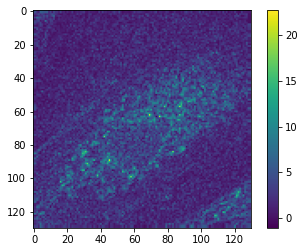

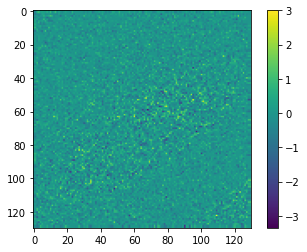

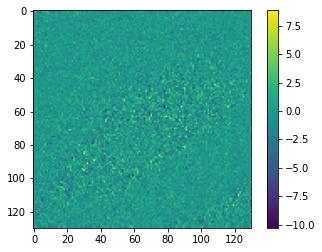

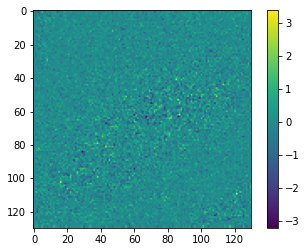

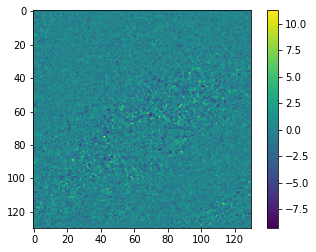

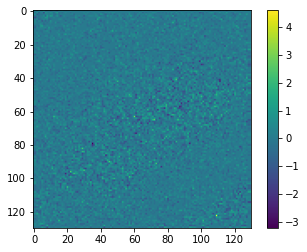

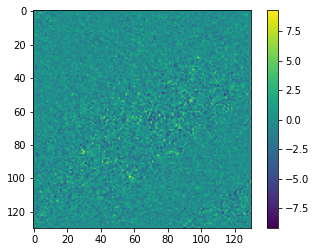

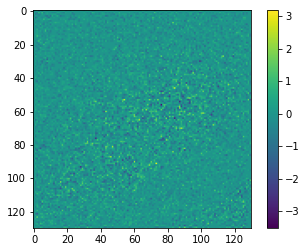

In [68]:
for k in Xw.keys():
    print(Xw[k].shape)
    plt.figure()
    plt.imshow(Xw[k].sum(2))
    plt.colorbar()